In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '211021_significance_of_feature_importances_human'
in_folder = '190428_predict_gtex_with_mirnas'

In [8]:
save_images = True

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(9606, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
# all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
#     detection_column='padj')

# tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
#        'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
#        'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
# pfus=[0]

In [12]:
# all_de = all_de[
#     (all_de['younger'] == 4) & 
#     (all_de['is_detected'] == True) &
#     (all_de['de_unit'] == 'both') &
#     (all_de['tissue'].isin(tissues_to_consider)) &
#     (all_de['pfu'].isin(pfus)) & 
#     (all_de['gene_ncbi'].isin(ref_genes))
# ]
# all_de['significant'] = all_de['padj'] < 0.05

In [13]:
from access_aging_data import companions

In [14]:
all_de = companions.tstoeger_190427_gtex()
all_de = all_de[
    (all_de['younger'].isin([2, 3])) &
    (all_de['older'].isin([4, 5, 6, 7]))
]

all_de.loc[:, 'significant'] = all_de['padj'] < 0.05
all_de.loc[:, 'reduced_tissue'] = all_de['tissue'].str.replace(
    ' - ', '_').str.replace(' ', '_').str.replace(
    '-', '_').str.replace('(','').str.replace(')', '')

all_de.loc[:, 'condition'] = all_de.loc[:, 'gender'] + 's_' + all_de['reduced_tissue'] + '_' + \
    all_de['older'].astype(int).astype(str) + '_vs_' + all_de['younger'].astype(int).astype(str)

all_de = all_de[all_de['gene_ncbi'].isin(ref_genes)]

In [15]:
import glob

In [16]:
master = all_de.copy()

In [17]:
master = master[['condition', 'significant', 'younger', 'older', 'tissue']].groupby(
    ['condition', 'younger', 'older', 'tissue']).agg(sum).reset_index()

In [18]:
sign = master[['condition', 'significant']].set_index('condition')

In [19]:
agg = []


for condition in master['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))

    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)

In [20]:
d = pd.merge(sign.reset_index(), df[['mean']].reset_index())

f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

zeros = sum(~f)

h = []
for j in range(zeros):
    h.append(-1 + random.randrange(0, 10)/20)
d.loc[~f, 'log_significant'] = h

d = pd.merge(d, master[['condition', 'younger', 'older']].drop_duplicates())

In [21]:
# agg = []


# for condition in d['condition'].unique():

#     p = export.get_material_path(
#         '{}/features_{}.csv'.format(in_folder, condition))

#     if os.path.exists(p):
#         h = pd.read_csv(p).set_index('feature')
#         h = h.mean(1).to_frame('contribution').rename_axis('feature').reset_index()
#         h.loc[:, 'condition'] = condition
#         agg.append(h)



# u = pd.concat(agg)

In [22]:
agg = []

for condition in d['condition'].unique():

    p = export.get_material_path(
        '{}/features_{}.csv'.format(in_folder, condition))

    if os.path.exists(p):
        h = pd.read_csv(p).set_index('feature')

        h = h.stack().rename_axis(['feature', 'iteration']).to_frame('importance').copy()
        h = h.reset_index()

        for it in h['iteration'].unique():
            g = h[h['iteration']==it].copy()
            g['ranked_importance'] = g['importance'].rank(ascending=False)

            g.sort_values('ranked_importance')
            g.loc[:, 'condition'] = condition
            agg.append(g)

In [23]:
d = pd.concat(agg)

In [24]:
interest =     [
        'rna_full_SumACGT',
        'gene_SumACGT',
        'rna_cds_SumACGT'
    ]

In [25]:
master

,condition,younger,older,tissue,significant
0,females_Adipose_Subcutaneous_4_vs_2,2.0,4.0,Adipose - Subcutaneous,229.0
1,females_Adipose_Subcutaneous_4_vs_3,3.0,4.0,Adipose - Subcutaneous,21.0
2,females_Adipose_Subcutaneous_5_vs_2,2.0,5.0,Adipose - Subcutaneous,1258.0
3,females_Adipose_Subcutaneous_5_vs_3,3.0,5.0,Adipose - Subcutaneous,101.0
4,females_Adipose_Subcutaneous_6_vs_2,2.0,6.0,Adipose - Subcutaneous,1085.0
...,...,...,...,...,...
586,males_Whole_Blood_5_vs_3,3.0,5.0,Whole Blood,402.0
587,males_Whole_Blood_6_vs_2,2.0,6.0,Whole Blood,1046.0
588,males_Whole_Blood_6_vs_3,3.0,6.0,Whole Blood,3865.0
589,males_Whole_Blood_7_vs_2,2.0,7.0,Whole Blood,137.0


In [26]:
helper = master[['condition', 'tissue', 'younger', 'older']].drop_duplicates()

In [27]:
g = pd.merge(d, helper)

In [28]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'
}

In [29]:
g['tissue'] = g['tissue'].replace(renamer)

In [30]:
g

,feature,iteration,importance,ranked_importance,condition,tissue,younger,older
0,rna_cds_SumACGT,0,0.061723,3.0,females_Adipose_Subcutaneous_4_vs_2,Adipose - Subcutaneous,2.0,4.0
1,rna_full_SumACGT,0,0.050772,5.0,females_Adipose_Subcutaneous_4_vs_2,Adipose - Subcutaneous,2.0,4.0
2,rna_full_CG,0,0.005102,32.0,females_Adipose_Subcutaneous_4_vs_2,Adipose - Subcutaneous,2.0,4.0
3,exons_max_ensembl,0,0.001731,63.0,females_Adipose_Subcutaneous_4_vs_2,Adipose - Subcutaneous,2.0,4.0
4,exons_min_ensembl,0,0.001225,86.0,females_Adipose_Subcutaneous_4_vs_2,Adipose - Subcutaneous,2.0,4.0
...,...,...,...,...,...,...,...,...
8986150,miRNA_miR-99a-3p,4,0.000000,1645.5,males_Whole_Blood_7_vs_3,Whole Blood,3.0,7.0
8986151,miRNA_miR-99a-5p,4,0.000000,1645.5,males_Whole_Blood_7_vs_3,Whole Blood,3.0,7.0
8986152,miRNA_miR-99b-3p,4,0.000000,1645.5,males_Whole_Blood_7_vs_3,Whole Blood,3.0,7.0
8986153,miRNA_miR-99b-5p,4,0.000000,1645.5,males_Whole_Blood_7_vs_3,Whole Blood,3.0,7.0


In [31]:
gg = g[
        (g['younger'].isin([2, 3])) &
        (g['older'].isin([6, 7])) &
        (g['feature'].isin(interest))
    ]

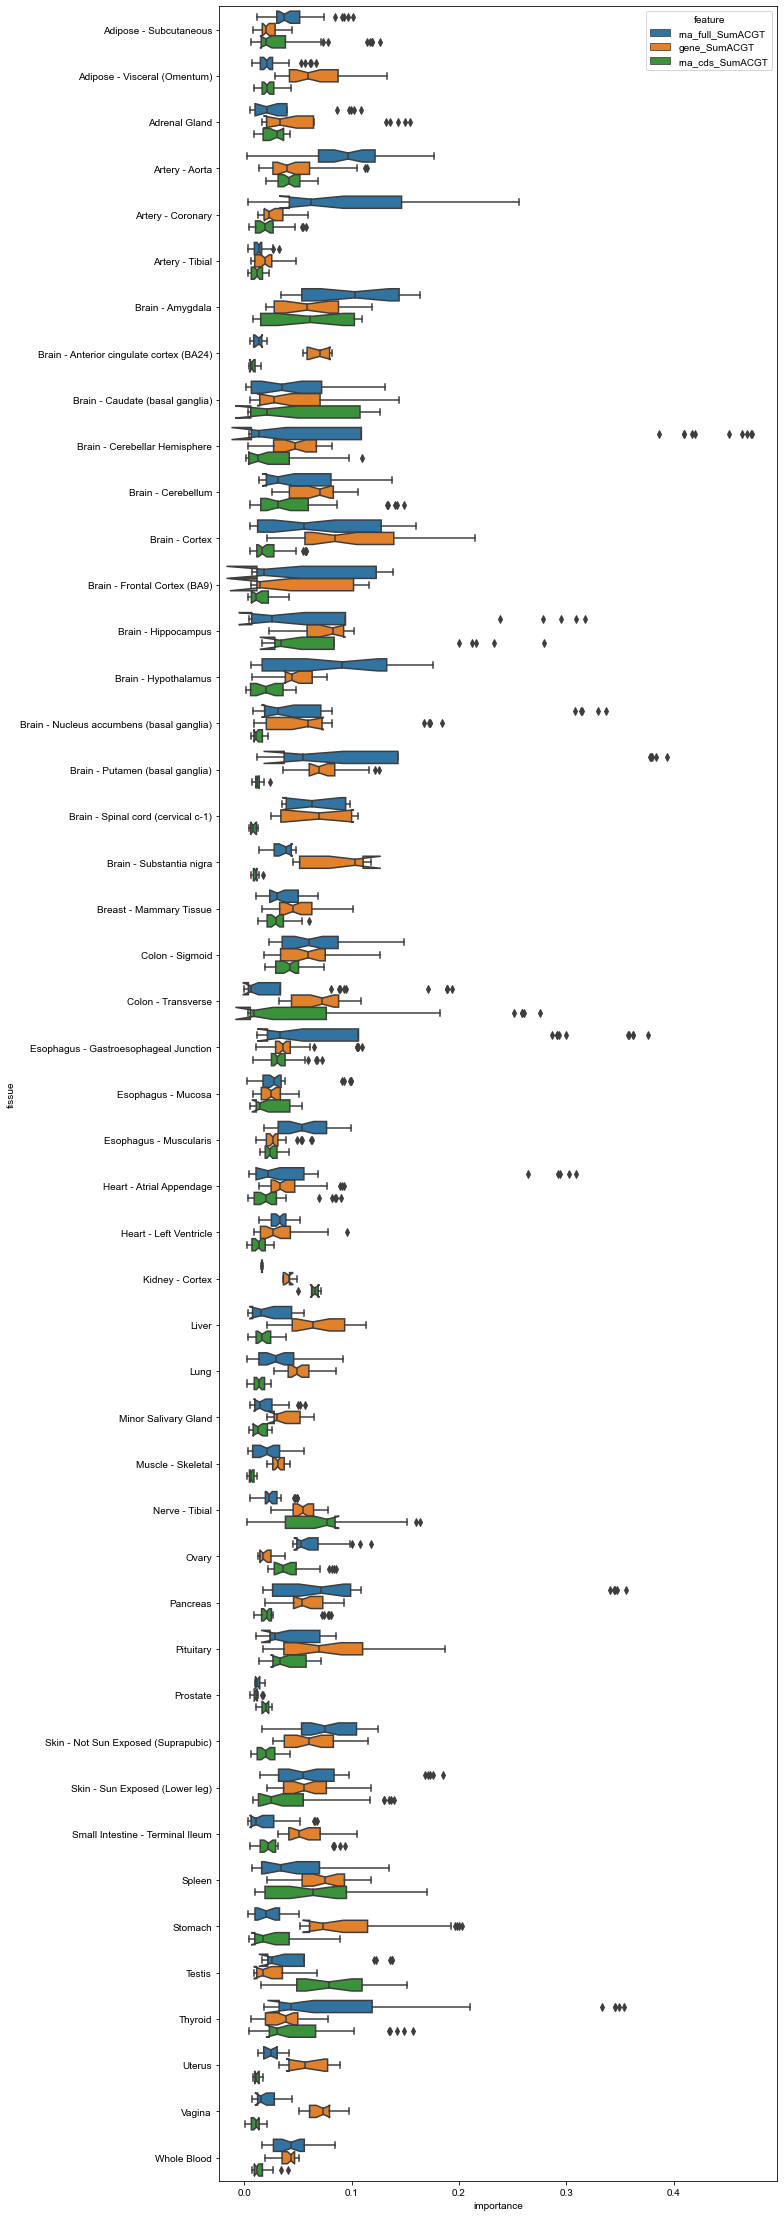

In [32]:
plt.figure(figsize=(10, 40))
sns.boxplot(
    y='tissue',
    x='importance',
    hue='feature',
    data=gg,
    order=sorted(gg['tissue'].unique()),   #   sorted(g['tissue'].unique()),
    hue_order=interest,
    notch=True
)

if save_images:
    export.export_image(
        '{}/effect_sizes_variabilty.pdf'.format(out_folder))



In [33]:
d = pd.merge(d, helper)

In [34]:
d['tissue'] = d['tissue'].replace(renamer)

In [35]:
d['condition_n'] = d['tissue'] + '_' + d['older'].astype(int).astype(str)

In [36]:
e = d.groupby(['condition_n', 'feature'])['importance'].mean().reset_index().pivot(
    index='feature', columns='condition_n', values='importance')

In [37]:
e = e.reindex(columns=sorted(e.columns))

In [38]:
u = e.rank(ascending=False).median(1).sort_values()

In [39]:
e = e.reindex(index=u.index)

In [40]:
if save_images:
    export.export_full_frame(
        '{}/importances.xlsx'.format(out_folder),
        e
    )
    
    export.export_full_frame(
        '{}/importances_ranked.xlsx'.format(out_folder),
        e.rank(ascending=False)
    )